In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


In [2]:
# limpieza sacada del notebook de "Limpieza de datos no numericos"
def reemplazar_por_metrica(df, variable, resumen, metrica):
    for p in resumen.index:
        df.loc[(df.tipodepropiedad == p) & (df[variable].isnull()), variable] = resumen.loc[p, metrica]
        
def reemplazar_por_moda(df, variable, resumen):
    reemplazar_por_metrica(df, variable, resumen, 'moda')

def limpieza_dataframe(df):
    # revisar si tiene sentido, 500 sin tipodepropiedad
    df.dropna(subset=['tipodepropiedad'], inplace=True)
    
    # columnas que no vamos a usar
    drop_columns = ['centroscomercialescercanos', 'escuelascercanas', 'usosmultiples', 'gimnasio',
               'fecha', 'lng', 'lat', 'idzona', 'id', 'direccion', 'titulo', 'descripcion', 'ciudad']
    if sum(df.columns.isin(drop_columns)) == len(drop_columns):
        df.drop(drop_columns, axis=1, inplace=True)
    
    # garages
    resumen_garages = pd.read_csv('r_garages.csv', index_col='tipodepropiedad')
    reemplazar_por_moda(df, 'garages', resumen_garages)
    
    # baños
    resumen_banos = pd.read_csv('r_banos.csv', index_col='tipodepropiedad')
    reemplazar_por_moda(df, 'banos', resumen_banos)
    
    # habitaciones
    resumen_habitacion = pd.read_csv('r_habitaciones.csv', index_col='tipodepropiedad')
    
    sin_habitaciones_y_deberian = list(resumen_habitacion[resumen_habitacion.porcentaje_no < 50].index)

    df.loc[(df.habitaciones.isnull())&(~df.tipodepropiedad.isin(sin_habitaciones_y_deberian)), 'habitaciones'] = 0

    for p in sin_habitaciones_y_deberian:
        df.loc[(df.habitaciones.isnull()) & (df.tipodepropiedad == p), 'habitaciones'] = resumen_habitacion.loc[p, 'moda']
    
    # antiguedad
    resumen_antiguedad = pd.read_csv('r_antiguedad.csv', index_col='tipodepropiedad')
    reemplazar_por_moda(df, 'antiguedad', resumen_antiguedad)

    # metrostotales y metroscubiertos
    df.loc[(~df.metroscubiertos.isnull()) & (df.metrostotales.isnull()), 'metrostotales'] = df.loc[(~df.metroscubiertos.isnull()) & (df.metrostotales.isnull()), 'metroscubiertos']
    df.loc[(df.metroscubiertos.isnull()) & (~df.metrostotales.isnull()), 'metroscubiertos'] = df.loc[(df.metroscubiertos.isnull()) & (~df.metrostotales.isnull()), 'metrostotales']


In [3]:
def graficar_correlacion(df, figsize=(6, 4), annot=True, title=None):
    corr = df.corr()
 
    # Heatmap
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    return sns.heatmap(corr, annot=annot, center=0.0, vmin=-1.0, vmax=1.0)

In [4]:
df_original = pd.read_csv('../data/train.csv')
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240000 non-null  int64  
 1   titulo                      234613 non-null  object 
 2   descripcion                 238381 non-null  object 
 3   tipodepropiedad             239954 non-null  object 
 4   direccion                   186928 non-null  object 
 5   ciudad                      239628 non-null  object 
 6   provincia                   239845 non-null  object 
 7   antiguedad                  196445 non-null  float64
 8   habitaciones                217529 non-null  float64
 9   garages                     202235 non-null  float64
 10  banos                       213779 non-null  float64
 11  metroscubiertos             222600 non-null  float64
 12  metrostotales               188533 non-null  float64
 13  idzona        

##### Limpiamos los datos que no tienen correlacion con nadie
Aca vemos cuales tienen correlacion con quienes. Nos vamos a quedar solo con aquellos que tengan algun tipo de correlacion (aunque sea minima) con el precio. De todas formas para nuestro analisis podemos ver que las columnas que vamos a sacar son datos que no nos aportan mucho de manera "intuitiva".

In [5]:
df = df_original.copy()
limpieza_dataframe(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239954 entries, 0 to 239999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tipodepropiedad  239954 non-null  object 
 1   provincia        239801 non-null  object 
 2   antiguedad       239954 non-null  float64
 3   habitaciones     239954 non-null  float64
 4   garages          239954 non-null  float64
 5   banos            239954 non-null  float64
 6   metroscubiertos  239954 non-null  float64
 7   metrostotales    239954 non-null  float64
 8   piscina          239954 non-null  float64
 9   precio           239954 non-null  float64
dtypes: float64(8), object(2)
memory usage: 20.1+ MB


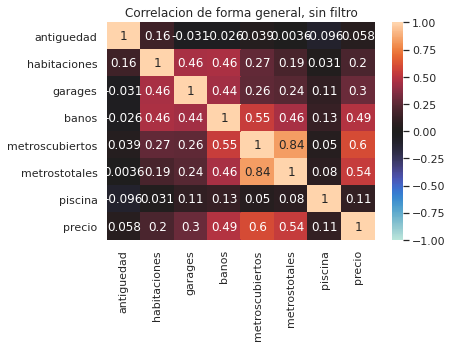

In [6]:
graficar_correlacion(df, figsize=(6,4), title="Correlacion de forma general, sin filtro")

In [7]:
# df.info()
propiedades = df['tipodepropiedad'].value_counts().index
df['tipodepropiedad'].value_counts()

Casa                             141717
Apartamento                       57341
Casa en condominio                19297
Terreno                            9945
Local Comercial                    3055
Oficina comercial                  1741
Bodega comercial                   1406
Edificio                           1396
Terreno comercial                  1326
Casa uso de suelo                   708
Quinta Vacacional                   395
Duplex                              343
Villa                               340
Inmuebles productivos urbanos       200
Rancho                              170
Local en centro comercial           165
Departamento Compartido             141
Otros                               134
Nave industrial                      76
Terreno industrial                   31
Huerta                               20
Lote                                  5
Garage                                1
Hospedaje                             1
Name: tipodepropiedad, dtype: int64

In [8]:
def segmentacion_propiedades(df):
    segmentos = {}
    
    departamentos = ["Apartamento", "Departamento Compartido"]
    segmentos["departamentos"] = df[df.tipodepropiedad.isin(departamentos)].copy()
    
    casas = ["Casa", "Casa en condominio", "Casa uso de suelo", "Duplex"]
    segmentos["casas"] = df[df.tipodepropiedad.isin(casas)].copy()
    
    comerciales = ["Local Comercial", "Oficina comercial", "Bodega comercial", "Terreno comercial", "Local en centro comercial"]
    segmentos["comerciales"] = df[df.tipodepropiedad.isin(comerciales)].copy()
    
    otros = departamentos + casas + comerciales
    segmentos['otros'] = df[~df.tipodepropiedad.isin(otros)].copy()

    return segmentos

segmentos = segmentacion_propiedades(df)

total = 0
for k in segmentos.keys():
    total += segmentos[k].size
    
assert total == df.size, "TIENEN QUE TENER LA MISMA CANTIDAD"

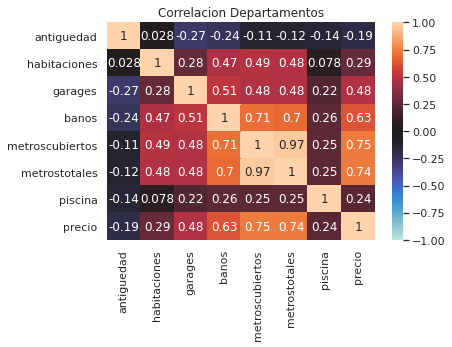

In [9]:
graficar_correlacion(segmentos['departamentos'], figsize=(6,4), title="Correlacion Departamentos")

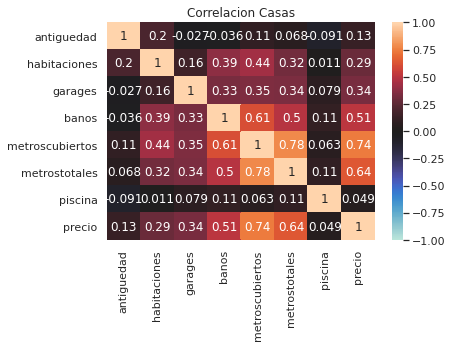

In [10]:
graficar_correlacion(segmentos['casas'], figsize=(6,4), title="Correlacion Casas")

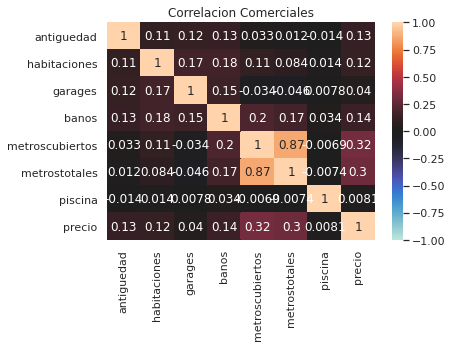

In [11]:
graficar_correlacion(segmentos['comerciales'], figsize=(6,4), title="Correlacion Comerciales")

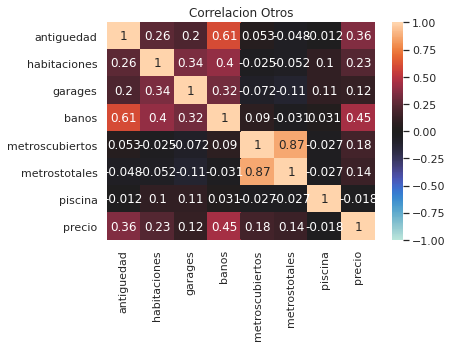

In [12]:
graficar_correlacion(segmentos['otros'], figsize=(6,4), title="Correlacion Otros")

#### La correlacion entre cada variable segun el tipo de propiedad (tal vez dentro de cada ciudad esto nos de distinto)
#### Interesante, la antiguedad tiene correlacion negativa con el precio cuando es departamento (mas caro, menos antiguo), y correlatividad positiva cuando es casa

# Analisis de cantidad de datos segun provincia

In [13]:
total_listings = len(df)
top_province = 7

provinces = list(df.groupby('provincia').count()['precio'].sort_values(ascending=False).head(top_province).index)
df_provinces = df[df.provincia.isin(provinces)]

total_provinces = df_provinces.count()['precio'].sum()

df.groupby('provincia').count()['precio'].sort_values(ascending=False).head(top_province)

provincia
Distrito Federal    58790
Edo. de México      41604
Jalisco             21238
Querétaro           16988
Nuevo León          15324
Puebla              10421
San luis Potosí      8411
Name: precio, dtype: int64

In [14]:
percentage = total_provinces * (100/total_listings)
print("Cantidad propiedades cubiertas por el top {} es {} ({}% del total)".format(top_province, total_provinces, percentage))

Cantidad propiedades cubiertas por el top 7 es 172776 (72.00380072847295% del total)


### Filtramos el dataframe que ya habia filtrado por tipo de propiedad y ahora sumamos el filtro de las 7 provincias que explicar el 70% del dataset

# Promedio del valor del metrocubierto por ciudad

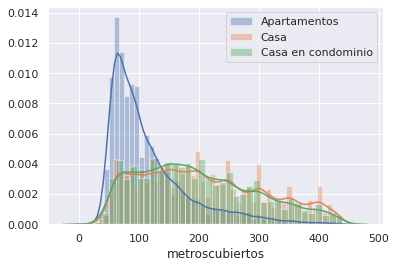

In [15]:
sns.distplot(df_provinces[(df_provinces.tipodepropiedad == "Apartamento")].metroscubiertos)
sns.distplot(df_provinces[(df_provinces.tipodepropiedad == "Casa")].metroscubiertos)
sns.distplot(df_provinces[df_provinces.tipodepropiedad == "Casa en condominio"].metroscubiertos)
plt.legend(['Apartamentos', 'Casa', 'Casa en condominio'])

In [16]:
df_provinces_bins = df_provinces.copy()
df_provinces_bins['metroscubiertos_bins'] = pd.cut(df_provinces.metroscubiertos, bins=np.linspace(15, 440, 440//5 - 2), labels=np.linspace(15, 440, 440//5 - 3))

In [17]:
def valor_metros_segun_ciudad(df_original, title):
    df = df_original.copy()
    df['preciomillones'] = df.precio/1000000
    data = df[['provincia', 'metroscubiertos_bins', 'preciomillones']].groupby(['provincia', 'metroscubiertos_bins']).mean().unstack('provincia')
    data.plot(figsize=(20,6))

    plt.title(title)
    plt.ylabel('precio promedio (en millones de pesos mexicanos)')
    plt.xlabel('metros cubiertos')
    plt.xticks(np.linspace(0, 80, 11), np.linspace(15, 440, 11, dtype=int))
    legends = [p[1] for p in data.columns]
    plt.legend(legends)
    plt.show()

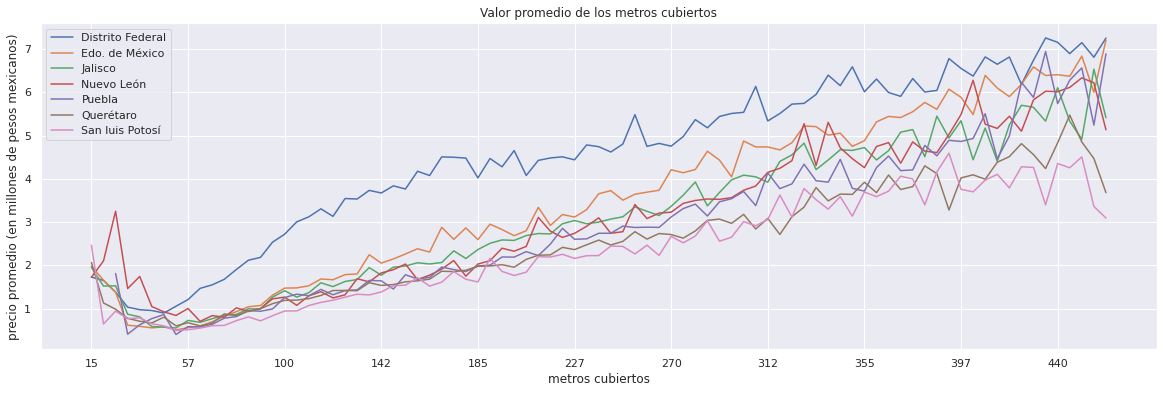

In [18]:
d = valor_metros_segun_ciudad(df_provinces_bins, "Valor promedio de los metros cubiertos")

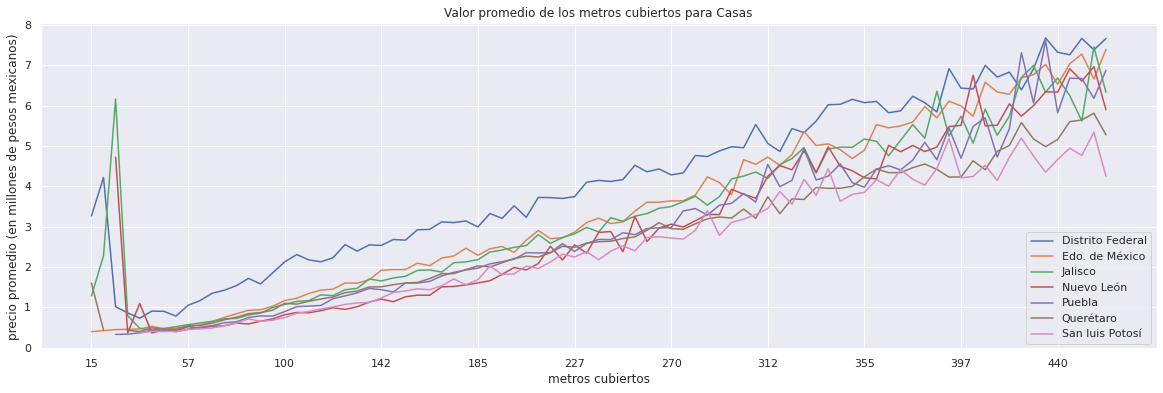

In [19]:
casass = (df_provinces_bins.tipodepropiedad == "Casa") | (df_provinces_bins.tipodepropiedad == "Casa uso de suelo") | (df_provinces_bins.tipodepropiedad == "Casa en condominio") | (df_provinces_bins.tipodepropiedad == "Duplex") 
valor_metros_segun_ciudad(df_provinces_bins[casass], "Valor promedio de los metros cubiertos para Casas")

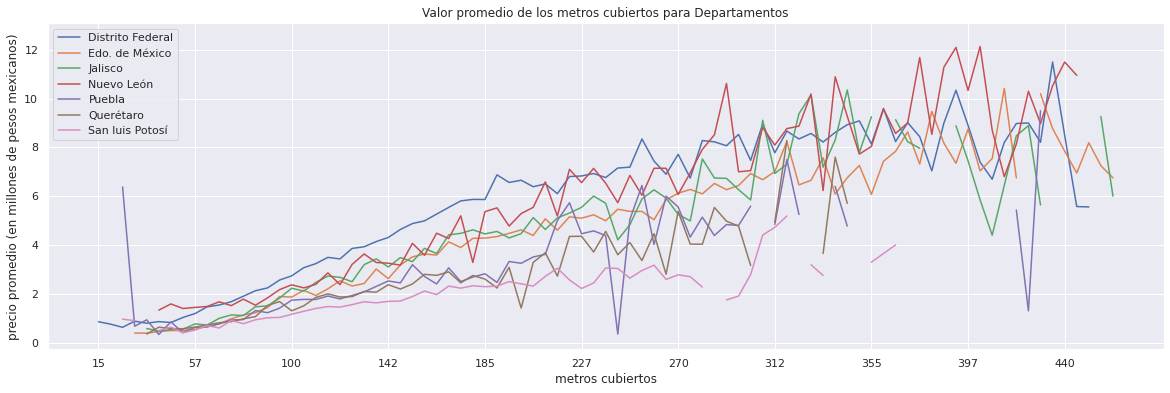

In [20]:
deptos = (df_provinces_bins.tipodepropiedad == "Apartamento") | (df_provinces_bins.tipodepropiedad == "Departamento Compartido")
valor_metros_segun_ciudad(df_provinces_bins[deptos], "Valor promedio de los metros cubiertos para Departamentos")

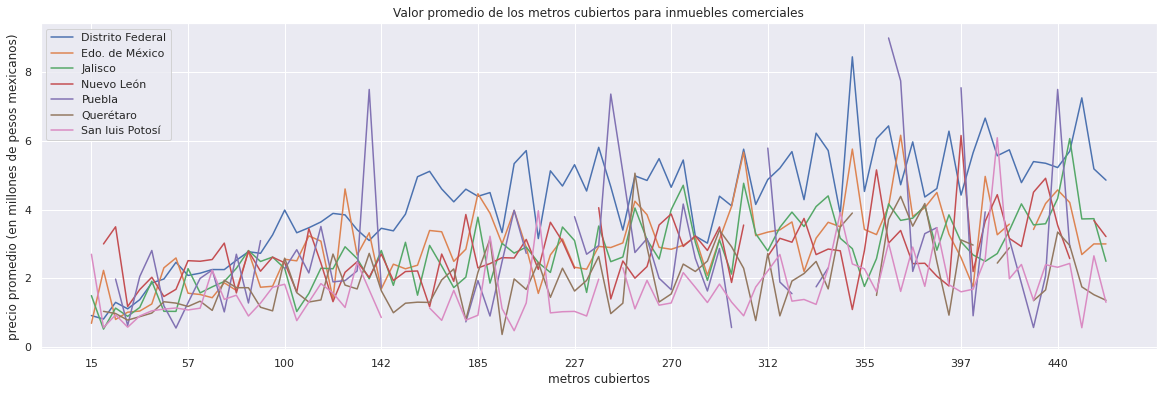

In [21]:
comercialess = (df_provinces_bins.tipodepropiedad == "Local en centro comercial") | (df_provinces_bins.tipodepropiedad == "Bodega comercial") | (df_provinces_bins.tipodepropiedad == "Oficina comercial") | (df_provinces_bins.tipodepropiedad == "Local Comercial") | (df_provinces_bins.tipodepropiedad == "Terreno comercial")
valor_metros_segun_ciudad(df_provinces_bins[comercialess], "Valor promedio de los metros cubiertos para inmuebles comerciales")

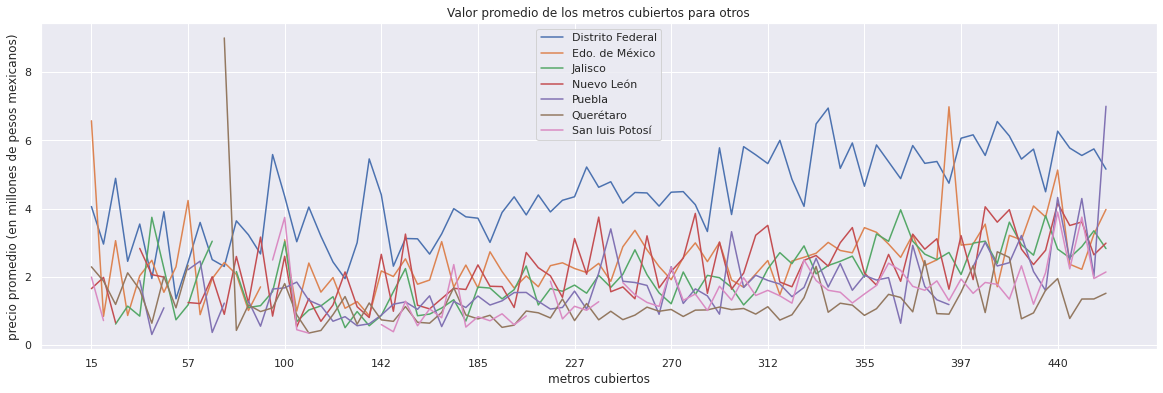

In [22]:
otros = (df_provinces_bins.tipodepropiedad == "Terreno") | (df_provinces_bins.tipodepropiedad == "Edificio") | (df_provinces_bins.tipodepropiedad == "Garage") | (df_provinces_bins.tipodepropiedad == "Hospedaje") | (df_provinces_bins.tipodepropiedad == "Lote") | (df_provinces_bins.tipodepropiedad == "Huerta") | (df_provinces_bins.tipodepropiedad == "Terreno industrial") | (df_provinces_bins.tipodepropiedad == "Nave industrial") | (df_provinces_bins.tipodepropiedad == "Otros") | (df_provinces_bins.tipodepropiedad == "Rancho") | (df_provinces_bins.tipodepropiedad == "Inmuebles productivos urbanos") | (df_provinces_bins.tipodepropiedad == "Villa") | (df_provinces_bins.tipodepropiedad == "Quinta Vacacional") 
valor_metros_segun_ciudad(df_provinces_bins[otros], "Valor promedio de los metros cubiertos para otros")

## Veamos las correlaciones entre las distintas variables despues de los dos filtros que se hicieron (de tipo de propiedad y provincias)

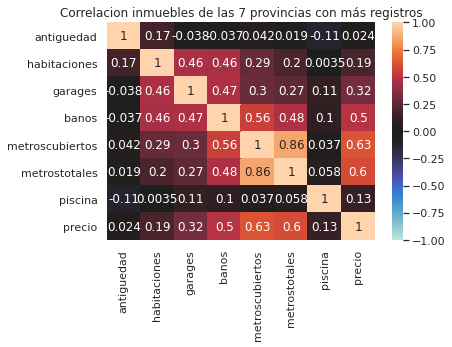

In [23]:
graficar_correlacion(df_provinces, figsize=(6,4), title="Correlacion inmuebles de las 7 provincias con más registros")

### Se comporta igual que antes, esta bien esto porque los filtros no modificaron la distribucion original :)